# NEW NETWORK

## Goal : 
The goal of this network is to group every user we got from the scrapped tweets and their friends (e.g people they are following) and go through different step to show :
* What kind of connection they share (bipartite or small world)
* If they follow the same people or not ? What does that mean ?
* Do they belong to the same community ? 

## Things to use : 
### Directed Graph
* Basic stats : What is the total number of nodes in the network? What is the total number of links? What's the average degree? What's the median degree?
* List the top 10 account by in-degree and out-degree. What is the interpretation of in-degree and out-degree in this case?
* Plot the distribution of in-degrees and out-degrees, binned using numpy.histogram. What is the most common degree?
* Plot the distribution of in-degrees and out-degrees one more time, this time plotted loglog scale.
* Describe the distributions (as you would in a well written figure caption). Do they look Poissonian? Power-law? Something in between?
* Plot a scatter plot of the the in- versus out- degree for all accounts using a loglog scale. Comment on the relation between the two.

### Undirected Graph

* Find the 5 most central accounts according to betweenness centrality. What role these accounts with high graph betweenness centrality play ?
* Find the 5 most central accounts according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
* Is the undirected version of the graph assortative with respect do degree? (e.g. do high-degree accounts tend to link to other high-degree accounts, and low-degree accounts to other low-degree accounts?). Interpreation ?

### Community

* Maybe do two branches : democrats/republicans
* Use the Python Louvain-algorithm implementation to find communities in the full network. Report the value of modularity found by the algorithm. 

### Bubble world / Small world
* Inspect how people connect to each other, is the small world hypothesis confirmed ? Is the bubble world hyposthesis confirmed ?

# Let's begin

In [2]:
#import tools for twitter API
from twitter import *

In [3]:
properties = dict(line.strip().split('=') 
          for line in open('keys.properties') 
          if not line.startswith('#') and not line.startswith('\n'))

In [7]:
CONSUMER_KEY = 'CONSUMER_KEY'
CONSUMER_SECRET = 'CONSUMER_SECRET'
OAUTH_TOKEN = 'OAUTH_TOKEN-lkfIU5F9uWRwwfnR7XiDlY5b1cOoAoe'
OAUTH_TOKEN_SECRET = 'OAUTH_TOKEN_SECRET'

In [8]:
# load our API credentials 
twitter = Twitter(
    auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET))

In [9]:
#Credentials for tweepy (use it as complement)
import tweepy

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth)

## Get the users from Mongo DB

For more efficiency we used Mongo data base to store all of our datas so they are available by anyone at anytime.

In [10]:
# import Mongo for python
import pymongo, pprint
from pymongo import MongoClient

In [11]:
properties = dict(line.strip().split('=') 
          for line in open('db.properties')
          if not line.startswith('#') and not line.startswith('\n'))

In [12]:
uri = 'mongodb://%s:%s@ds161487.mlab.com:61487/election_tweets' % (properties['username'], properties['password'])
client = MongoClient(uri)

In [13]:
db = client.election_tweets
tweet_collection = db.tweets
user_collection = db.users

In [14]:
print user_collection.count()

87501


## Create the network

Now that everything is settled we can start working on our tweet. 

In [2]:
#Import everything useful for networks
import networkx as nx
import matplotlib.pyplot as plt

In [19]:
import json
import time
import datetime
import os

In [20]:
# Create the graph
directed = nx.DiGraph()

In [21]:
# All twitter users in the database
users = user_collection.find()

In [22]:
for i in users:
    # We need to deal with the rate limit of twitter API
    # It's not the best way but it works and we don't really need more
    try:
        #select the user name
        user = api.get_user(i["_id"])
        username = user.screen_name

        # perform a basic search 
        query = twitter.friends.ids(screen_name = username)
        print "found %d friends" % (len(query["ids"]))

        # now we loop through them to pull out more info, in blocks of 100.
        for n in range(0, len(query["ids"]), 100):
            ids = query["ids"][n:n+100]

            # create a subquery, looking up information about these users
            subquery = twitter.users.lookup(user_id = ids)

            for user_q in subquery:
                # now print out user info, starring any users that are Verified.
                directed.add_node(user_q["screen_name"])
                directed.add_edge(username, user_q["screen_name"])
                #print " [%s] %s" % ("*" if user["verified"] else " ", user["screen_name"])
    except Exception as e:
        #Sleep while we cannot access twitter
        print "Rate Limit Error: %s" % e
        time.sleep(15 * 60 + 15)
        continue

Rate Limit Error: Twitter sent status 429 for URL: 1.1/friends/ids.json using parameters: (oauth_consumer_key=UAclDqCOIjWcR18OM33tFpUko&oauth_nonce=10275620091893754421&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1480501680&oauth_token=771302832909746176-lkfIU5F9uWRwwfnR7XiDlY5b1cOoAoe&oauth_version=1.0&screen_name=Sttephy&oauth_signature=JNOS9HZ6YPVnjBKtexa5jfdE7V0%3D)
details: {u'errors': [{u'message': u'Rate limit exceeded', u'code': 88}]}
found 255 friends
found 165 friends
found 431 friends
found 911 friends
found 165 friends
found 5000 friends
found 253 friends
found 1265 friends
found 195 friends
found 650 friends
found 398 friends
found 167 friends
found 5000 friends
found 347 friends
found 26 friends
Rate Limit Error: Twitter sent status 429 for URL: 1.1/friends/ids.json using parameters: (oauth_consumer_key=UAclDqCOIjWcR18OM33tFpUko&oauth_nonce=12607340402452339246&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1480502742&oauth_token=771302832909746176-lkfIU5F9uWRwwfnR

CursorNotFound: Cursor not found, cursor id: 5308878337434

** Draw is way too expensive, we have to do some work on the graph before. But first we save the network as a txt file so we won't have to run the code again **

In [ ]:
import pickle
#Saving the network
pickle.dump(directed, open('graph.txt', 'w'))

In [31]:
#Open the network
dire = pickle.load(open('./graph.txt'))

## Basic Stats

In [17]:
import numpy as np
%matplotlib inline 

In [32]:
#Number of node
print "The graph has %d nodes" % directed.number_of_nodes() , "and and %d edges "% directed.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed.in_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed.out_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)

print node_in_degree_tuples[:10]
print node_out_degree_tuples[:10]




The graph has 64728 nodes and and 78788 edges 
[(u'wikileaks', 30), (u'realDonaldTrump', 27), (u'BarackObama', 27), (u'POTUS', 24), (u'HillaryClinton', 24), (u'BernieSanders', 23), (u'KellyannePolls', 22), (u'mike_pence', 22), (u'DRUDGE_REPORT', 21), (u'RealBenCarson', 21)]
[(u'sallykohn', 4736), (u'ladygaga', 4557), (u'wikileaks', 4527), (u'StevenTDennis', 4507), (u'stuartpstevens', 4399), (u'Shottyisms', 3415), (u'bad_bad_bernie', 2986), (u'CaptainsLog2016', 2906), (u'SanFranMoman', 2692), (u'Trevor90666770', 2541)]


* The following section draws the distribution graphs.

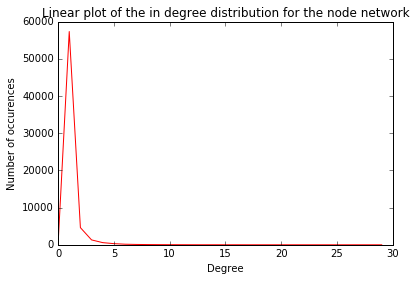

In [26]:
#Distributions
# Compute min and max values for the degrees
node_in_degree = map(lambda x: x[1], node_in_degree_tuples)
node_out_degree = map(lambda x: x[1], node_out_degree_tuples)
max_in_degree = max(node_in_degree)
min_in_degree = min(node_in_degree)
max_out_degree = max(node_out_degree)
min_out_degree = min(node_out_degree)

# Compute the bins for our degree distribution
bins_in = [i for i in range(min_in_degree, max_in_degree+1)]
bins_out = [i for i in range(min_out_degree, max_out_degree+1)]

degrees_in_hist, degrees_in_bin = np.histogram(node_in_degree, bins=bins_in)
degrees_out_hist, degrees_out_bin = np.histogram(node_out_degree, bins=bins_out)

plt.plot(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the in degree distribution for the node network')
plt.show()

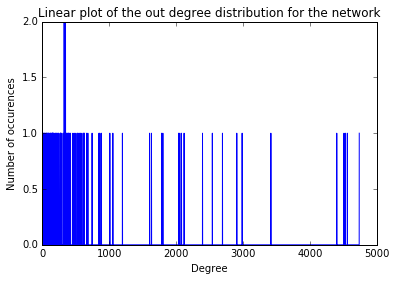

In [38]:
plt.plot(degrees_out_bin[:-1], degrees_out_hist, 'b')
plt.axis([0, 5000, 0, 2])
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the out degree distribution for the network')
plt.show()

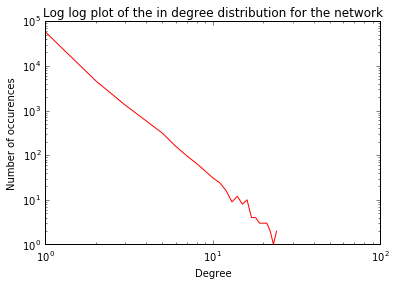

In [39]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the in degree distribution for the network')
plt.show()

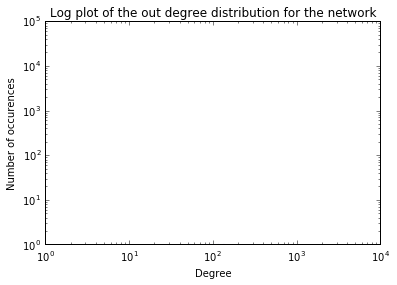

In [42]:


plt.loglog(degrees_out_bin[:-1], degrees_out_hist)
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log plot of the out degree distribution for the network')
plt.show()



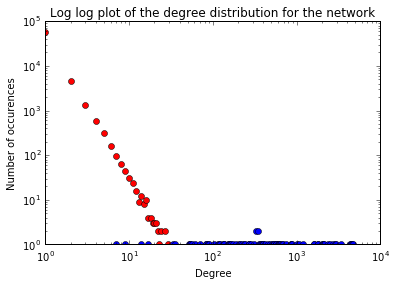

In [30]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'ro')
plt.loglog(degrees_out_bin[:-1], degrees_out_hist, 'o')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the degree distribution for the network')
plt.show()

## Centrality and other stuffs

* The following section draws the graph and weigth the size of a node according to its degree. The plot itself is not really important, but it looks cool !

The graph is way too big to be drawn, so we decide to make a smaller graph. The idea is to keep the node with a degree greater than 3 only. We have a lot of isolated accounts that are quite useless in this centrality analysis.

In [72]:
#Compute a list of nodes with a degree < 1 to remove
to_remove = [node for node,degree in dire.degree().items() if degree < 3]

In [73]:
# We make a copy of the original graph
test = dire.copy()

In [74]:
#We remove the nodes
test.remove_nodes_from(to_remove)

In [101]:
#Number of node
print "The graph has now %d nodes" % test.number_of_nodes() , "and and %d edges "% test.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, test.in_degree(node)) for node in test.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, test.out_degree(node)) for node in test.nodes()], key=lambda (n, d): -d)
print "The top ten accounts by in degree are : "
print node_in_degree_tuples[:10]
print "The top ten accounts by out degree are : "
print node_out_degree_tuples[:10]

The graph has now 2785 nodes and and 12228 edges 
The top ten accounts by in degree are : 
[(u'wikileaks', 30), (u'realDonaldTrump', 27), (u'BarackObama', 27), (u'POTUS', 24), (u'HillaryClinton', 24), (u'BernieSanders', 23), (u'mike_pence', 22), (u'KellyannePolls', 22), (u'DRUDGE_REPORT', 21), (u'RealBenCarson', 21)]
The top ten accounts by out degree are : 
[(u'sallykohn', 885), (u'StevenTDennis', 777), (u'stuartpstevens', 733), (u'Trevor90666770', 726), (u'sanchezcan', 724), (u'kurteichenwald', 655), (u'PPolenberg', 439), (u'halsteadg048', 405), (u'jojoh888', 351), (u'bad_bad_bernie', 317)]


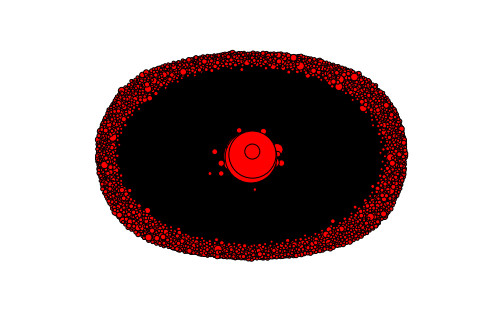

In [78]:
#We can now plot the network 
d = nx.degree(test)
nx.draw(test, nodelist=d.keys(), node_size=[v * 3 for v in d.values()])
plt.show()

In [79]:
plt.savefig("graph.pdf")

* We will now go through some centrality measures. We perform these algorithms on the reduced network as these measures are very costly 

In [80]:
# We need an undirectd graph
undir = test.to_undirected()

In [81]:
#Betweeness centrality
between_centrality = nx.betweenness_centrality(undir)
between_centrality_sorted = sorted(between_centrality.iteritems(), key=lambda (name, value): -value)

print "Betweenes : The 5 most central accounts are :\n" 
print between_centrality_sorted[:5]

Betweenes : The 5 most central accounts are :

[(u'Trevor90666770', 0.19344522557156732), (u'sallykohn', 0.17619084394519682), (u'stuartpstevens', 0.14708972224880318), (u'StevenTDennis', 0.13828282353275367), (u'sanchezcan', 0.12851328806855555)]


In [83]:
#Eigen vectore centrality
eigen_centrality = nx.eigenvector_centrality(undir)
eigen_centrality_sorted = sorted(eigen_centrality.iteritems(), key=lambda (name, value): -value)

print "Eigen : The 5 most central accounts are :\n" 
print eigen_centrality_sorted[:5]

Eigen : The 5 most central accounts are :

[(u'sallykohn', 0.3055201383264885), (u'sanchezcan', 0.27596570515958063), (u'StevenTDennis', 0.27116859006756233), (u'stuartpstevens', 0.264643703632886), (u'kurteichenwald', 0.2609156928239351)]


In [85]:
#In degree centrality
in_centrality = nx.in_degree_centrality(test)
in_centrality_sorted = sorted(in_centrality.iteritems(), key=lambda (name, value): -value)

print "In degree centrality : The 5 most central accounts are :\n" 
print in_centrality_sorted[:5]

In degree centrality : The 5 most central accounts are :

[(u'wikileaks', 0.010775862068965518), (u'realDonaldTrump', 0.009698275862068966), (u'BarackObama', 0.009698275862068966), (u'POTUS', 0.008620689655172414), (u'HillaryClinton', 0.008620689655172414)]


In [86]:
#out degree centrality
out_centrality = nx.out_degree_centrality(test)
out_centrality_sorted = sorted(out_centrality.iteritems(), key=lambda (name, value): -value)

print "out degree centrality : The 5 most central accounts are :\n" 
print out_centrality_sorted[:5]

out degree centrality : The 5 most central accounts are :

[(u'sallykohn', 0.31788793103448276), (u'StevenTDennis', 0.2790948275862069), (u'stuartpstevens', 0.26329022988505746), (u'Trevor90666770', 0.2607758620689655), (u'sanchezcan', 0.2600574712643678)]


In [94]:
#Now we want to check if there is a path between Clinton and Trump on both networks
print nx.has_path(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.has_path(test, u'HillaryClinton',  u'realDonaldTrump')

True
False


In [99]:
print nx.shortest_path_length(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.shortest_path_length(undir, u'HillaryClinton',  u'wikileaks')
print nx.shortest_path_length(undir, u'BarackObama',  u'realDonaldTrump')

2
2
2
